# New York State's Influence on National Numbers
This workbook compares US trends with and without NY.

In [48]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.max_open_warning': 0})
from data_mappings import state_full_names
import squarify

In [42]:
states = pd.read_csv("https://covidtracking.com/api/states/daily.csv")
states['date'] = pd.to_datetime(states['date'],format='%Y%m%d')
states['abrv'] = states['state']
states['state'] = states['state'].map(state_full_names)
states.rename(columns={
    'death': 'deaths',
    'deathIncrease': 'new_deaths',
    'positive': 'cases',
    'positiveIncrease': 'new_cases',
    'hospitalizedIncrease': 'new_hospitalizations',
    'onVentilatorCurrently': 'on_ventilator',
    'inIcuCurrently': 'in_icu'
},inplace=True)
states = states.sort_values(by=['state','date'])

In [4]:
national = states.groupby('date').agg({
    'new_cases': sum,
    'new_deaths': sum,
    'totalTestResultsIncrease': sum,
    'hospitalizedCurrently': sum,
    'new_hospitalizations': sum,
    'in_icu': sum,
    'on_ventilator': sum,
    'recovered': sum
}).reset_index()

In [5]:
national_xNY = states[states.state != 'New York'].groupby('date').agg({
    'new_cases': sum,
    'new_deaths': sum,
    'totalTestResultsIncrease': sum,
    'hospitalizedCurrently': sum,
    'new_hospitalizations': sum,
    'in_icu': sum,
    'on_ventilator': sum,
    'recovered': sum
}).reset_index()

In [6]:
national.loc[:,'nc7d'] = national['new_cases'].rolling(window=7).mean()
national.loc[:,'nd7d'] = national['new_deaths'].rolling(window=7).mean()
national.loc[:,'ntri7d'] = national['totalTestResultsIncrease'].rolling(window=7).mean()
national.loc[:,'new_recovered'] = national['recovered'] - national['recovered'].shift(1)
national.loc[:,'rec7d'] = national['new_recovered'].rolling(window=7).mean()
national.loc[:,'nh7d'] = national['new_hospitalizations'].rolling(window=7).mean()
national.replace(np.nan,0,inplace=True)

In [7]:
national_xNY.loc[:,'nc7d'] = national_xNY['new_cases'].rolling(window=7).mean()
national_xNY.loc[:,'nd7d'] = national_xNY['new_deaths'].rolling(window=7).mean()
national_xNY.loc[:,'ntri7d'] = national_xNY['totalTestResultsIncrease'].rolling(window=7).mean()
national_xNY.loc[:,'new_recovered'] = national_xNY['recovered'] - national_xNY['recovered'].shift(1)
national_xNY.loc[:,'rec7d'] = national_xNY['new_recovered'].rolling(window=7).mean()
national_xNY.loc[:,'nh7d'] = national_xNY['new_hospitalizations'].rolling(window=7).mean()
national_xNY.replace(np.nan,0,inplace=True)

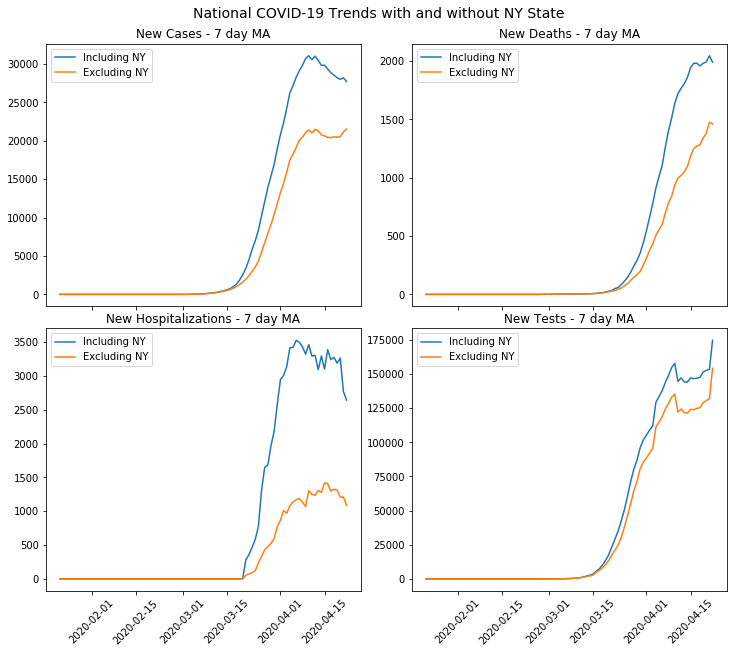

In [8]:
fig, axes = plt.subplots(2, 2, sharex='col', figsize=(10,8))
plt.tight_layout(pad=0.4, w_pad=2, h_pad=1.2)
fig.suptitle('National COVID-19 Trends with and without NY State', fontsize=14, y=1.05);

# top left plot
ax = axes[0,0]
ax.set_title('New Cases - 7 day MA')
ax.plot(national.date, national.nc7d, label='Including NY')
ax.plot(national_xNY.date, national_xNY.nc7d, label='Excluding NY')
ax.legend()
ax.tick_params(axis='y')
plt.setp(ax.xaxis.get_majorticklabels(), rotation=45)

# top right plot
ax = axes[0,1]
ax.set_title('New Deaths - 7 day MA')
ax.plot(national.date, national.nd7d, label='Including NY')
ax.plot(national_xNY.date, national_xNY.nd7d, label='Excluding NY')
ax.legend()
ax.tick_params(axis='y')
plt.setp(ax.xaxis.get_majorticklabels(), rotation=45)

# bottom left plot
ax = axes[1,0]
ax.set_title('New Hospitalizations - 7 day MA')
ax.plot(national.date, national.nh7d, label='Including NY')
ax.plot(national_xNY.date, national_xNY.nh7d, label='Excluding NY')
ax.legend()
plt.setp(ax.xaxis.get_majorticklabels(), rotation=45)

# bottom right plot
ax = axes[1,1]
ax.set_title('New Tests - 7 day MA')
ax.plot(national.date, national.ntri7d, label='Including NY')
ax.plot(national_xNY.date, national_xNY.ntri7d, label='Excluding NY')
ax.legend()        
plt.setp(ax.xaxis.get_majorticklabels(), rotation=45);

## Treemap of Cases by State

In [113]:
# get state populations and other variables
state_populations = pd.read_csv('state population and area.csv')
state_populations.head()

,State,TotalArea,LandArea,WaterArea,Density,Pop
0,Alaska,665384,570641,94743,1.2863,734002
1,Texas,268596,261232,7365,112.8204,29472295
2,California,163696,155779,7916,256.3727,39937489
3,Montana,147040,145546,1494,7.4668,1086759
4,New Mexico,121590,121298,292,17.2850,2096640


In [118]:
state_totals = states.groupby(['state','abrv'])[['cases','deaths']]\
    .max().sort_values(by='cases',ascending=False).reset_index()\
    .merge(state_populations,left_on='state',right_on='State')[['State','abrv','Pop','deaths','cases']]
state_totals.set_index('State',inplace=True)
state_totals['cfr'] = state_totals['deaths'] / state_totals['cases']
state_totals['deaths_per_million'] = 1E6*state_totals['deaths'] / state_totals['Pop']
state_totals['% infected'] = 100 * state_totals['cases'] / state_totals['Pop']
state_totals.head()

,abrv,Pop,deaths,cases,cfr,deaths_per_million,% infected
State,,,,,,,
New York,NY,19440469,15302.0,257216.0,0.059491,787.120928,1.323096
New Jersey,NJ,8936574,5063.0,95865.0,0.052814,566.548210,1.072727
Massachusetts,MA,6976597,2182.0,42944.0,0.050810,312.759932,0.615544
California,CA,39937489,1354.0,35396.0,0.038253,33.902983,0.088629
Illinois,IL,12659682,1565.0,35108.0,0.044577,123.620799,0.277321


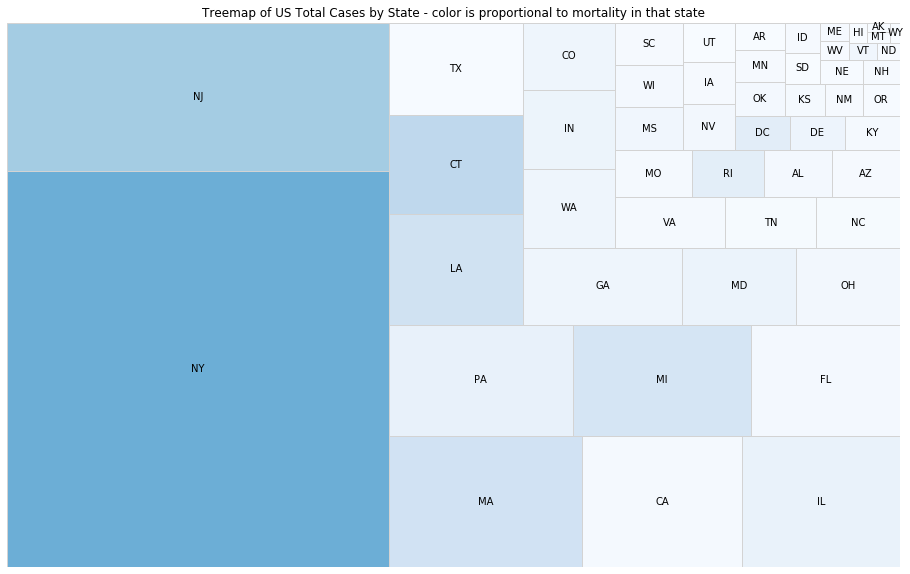

In [124]:
# see https://python-graph-gallery.com/202-treemap-with-colors-mapped-on-values/
# squarify source code at https://github.com/laserson/squarify/blob/master/squarify/__init__.py
cmap = matplotlib.cm.Blues
mini=min(state_totals.deaths_per_million)
maxi=max(2*state_totals.deaths_per_million) # to avoid black text on dark blue background
norm = matplotlib.colors.Normalize(vmin=mini, vmax=maxi)
colors = [cmap(norm(value)) for value in state_totals.deaths_per_million]

fig, ax = plt.subplots(1, 1, figsize=(16,10))
ax.set_title('Treemap of US Total Cases by State - color is proportional to mortality in that state')
squarify.plot(sizes=state_totals.cases, label=state_totals.abrv, color=colors, bar_kwargs={'edgecolor': 'lightgrey'} )
plt.axis('off')
plt.show()